# Generating MNIST adversarial examples with AdvGAN

In [ ]:
!pip install git+https://github.com/tensorflow/docs
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

from losses import carlini_wagner_loss_fn, l2_norm_soft_hinge_loss_fn
from models.advgan import AdvGAN
from models.components import get_discriminator, get_resnet_generator
from models.target import MNISTConvTarget
from util import images_to_gif

In [3]:
IMAGES_DIR = 'images'
WEIGHTS_DIR = 'weights'

BASE_FILENAME = 'advgan_mnist'

In [4]:
import os

if not os.path.isdir(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

if not os.path.isdir(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

In [5]:
TARGET_LABEL = 3  # the chosen label for the targeted attack

BUFFER_SIZE = 60000
BATCH_SIZE = 256

INPUT_SHAPE = (28, 28, 1)
OUTPUT_CHANNELS = 1

## Data loading and preprocessing

Load the MNIST training set images:

In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(f'training set: {train_images.shape}, {train_labels.shape}')
print(f'test set: {test_images.shape}, {test_labels.shape}')

training set: (60000, 28, 28), (60000,)
test set: (10000, 28, 28), (10000,)


Reshape the images to $28 \times 28 \times 1$ and normalize them to $[-1, 1]$:

In [7]:
train_images = train_images.reshape(train_images.shape[0], *INPUT_SHAPE).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_images.shape

(60000, 28, 28, 1)

In [8]:
test_images = test_images.reshape(test_images.shape[0], *INPUT_SHAPE).astype('float32')
test_images = (test_images - 127.5) / 127.5
test_images.shape

(10000, 28, 28, 1)

Remove the target label images from the training set:

In [9]:
train_filter = (train_labels != TARGET_LABEL)

train_images, train_labels = train_images[train_filter], train_labels[train_filter]
train_images.shape

(53869, 28, 28, 1)

Shuffle and batch the training set data:

In [10]:
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## AdvGAN

[AdvGAN](https://arxiv.org/pdf/1801.02610.pdf) is a generative adversarial network for creating adversarial examples that is based on image-to-image translation models such as [pix2pix](https://openaccess.thecvf.com/content_cvpr_2017/papers/Isola_Image-To-Image_Translation_With_CVPR_2017_paper.pdf) and [CycleGAN](https://openaccess.thecvf.com/content_ICCV_2017/papers/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.pdf).

It consists of three parts: the generator, the discriminator, and the target of the adversarial attacks.

The generator creates adversarial perturbations for the original images it receives as input, while the discriminator tries to distinguish between the original images and the adversarial images.

The target network is used for computing the adversarial loss, which guides the generator during training towards creating more successful adversarial images.

### Generator

The generator receives an image as input and shapes it into an adversarial perturbation of the desired size ($28 \times 28 \times 1$ for MNIST).

It is a modified ResNet of the following structure (taken from the [AdvGAN](https://openreview.net/pdf?id=HknbyQbC-) paper):

`c3s1-8, d16, d32, r32, r32, r32, r32, u16, u8, c3s1-3`,

where

* `c3s1-k` is a $3 \times 3$ Convolution-InstanceNorm-ReLU
layer with `k` filters and stride 1,
* `rk` is a residual block of two $3 \times 3$ convolutional layers
with the same numbers of filters,
* `dk` (downsampling layer) is a $3 \times 3$ Convolution-InstanceNorm-ReLU layer with
`k` filters and stride 2, and
* `uk` (upsampling layer) is a $3 \times 3$ FractionallyStridedConvolution-InstanceNorm-ReLU layer
with `k` filters, and stride 1/2.

Create a generator of the specified structure:

In [11]:
generator = get_resnet_generator(
    INPUT_SHAPE,
    filters=8,
    kernel_size=(3, 3),
    num_downsampling_blocks=2,
    num_residual_blocks=4,
    num_upsampling_blocks=2,
    name='mnist_generator'
)

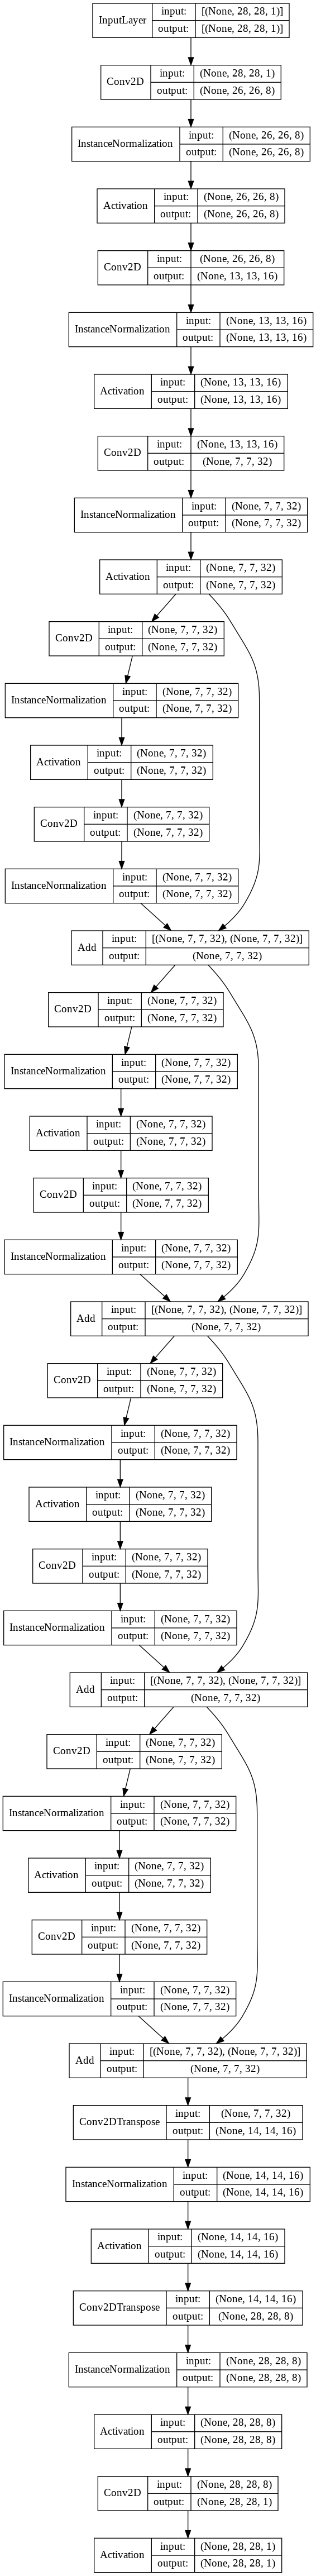

In [12]:
generator.build((BATCH_SIZE, *INPUT_SHAPE))
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=False)

### Discriminator

The discriminator is a CNN-based binary classifier that tries to differentiate between real images (from the training set) and fake images (created by the generator).

Its structure is taken from the [AdvGAN](https://openreview.net/pdf?id=HknbyQbC-) paper:

`C8, C16, C32, FC`,

where `Ck` denotes a $4 \times 4$ Convolution-InstanceNorm-LeakyReLU layer with `k` filters and stride 2.
The output of the last convolutional layer is flattened, and a fully-connected (`FC`) layer is applied to produce a 1-dimensional output.
There is no InstanceNorm for the first layer.
The LeakyReLU slope is set to 0.2.

In [13]:
discriminator = get_discriminator(
    INPUT_SHAPE,
    filters=8,
    num_downsampling_blocks=2,
    name='mnist_discriminator'
)

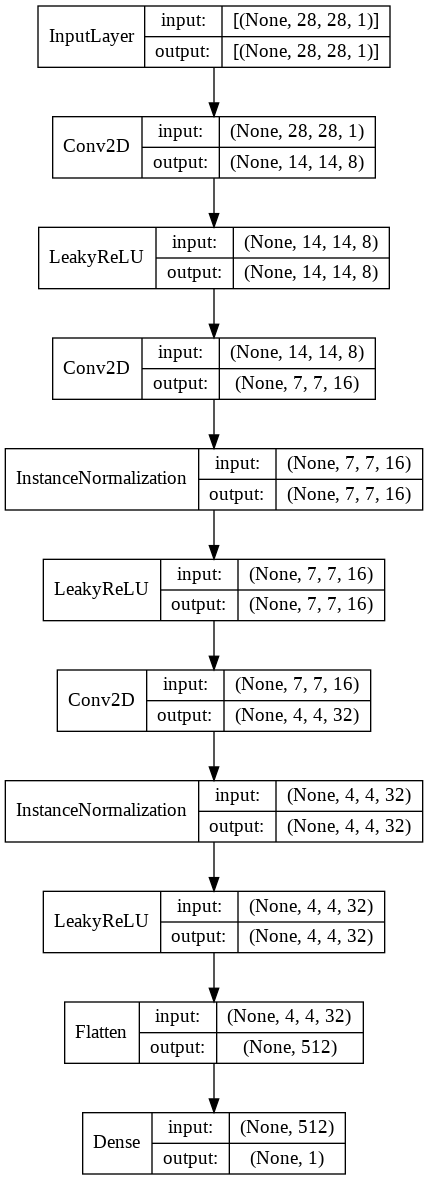

In [14]:
discriminator.build((BATCH_SIZE, *INPUT_SHAPE))
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=False)

### Target

The pre-trained `MNISTConvTarget` model is the target of the attacks.
It is used for computing the adversarial loss, which guides the generator during training.

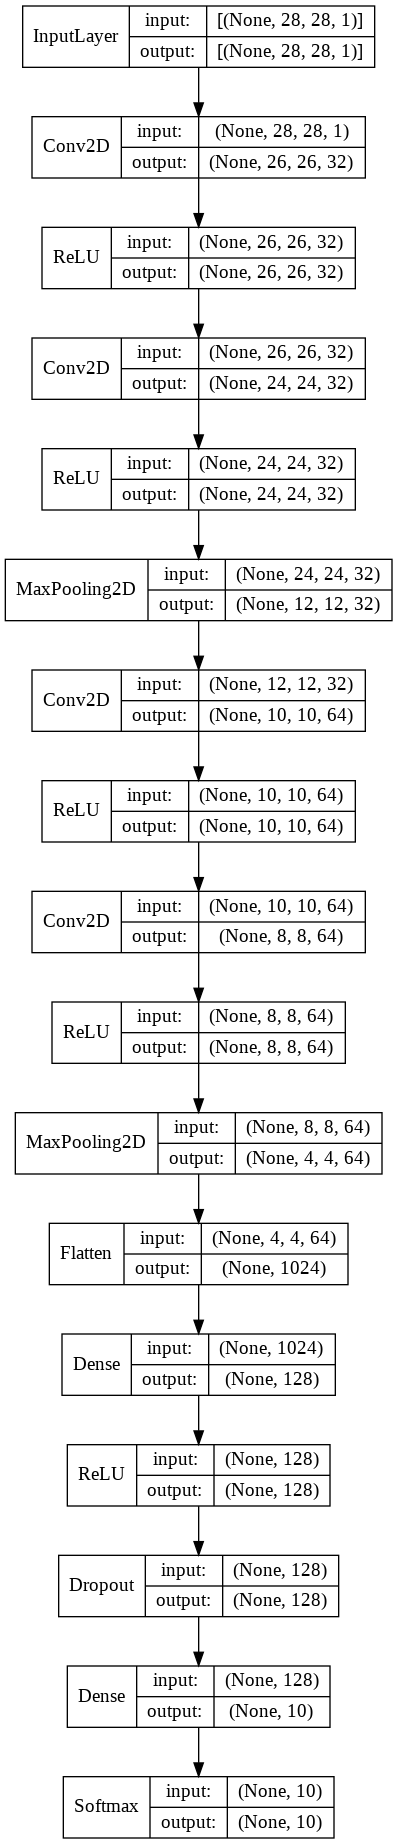

In [15]:
target = MNISTConvTarget()
tf.keras.utils.plot_model(target.model, show_shapes=True, show_layer_names=False)

In [16]:
weights_path = f'{WEIGHTS_DIR}/mnist_conv_target_20220106120545.h5'

target.built = True
target.load_weights(weights_path)

### Training

In each training step, the generator receives a batch of training set images $\mathbf{x}$ as input and uses it to generate a batch of adversarial perturbations $G(\mathbf{x})$.
The adversarial images are obtained by combining the training set images with the perturbations: $\mathbf{x}_{adv} = \mathbf{x} + G(\mathbf{x})$ (making sure that the values remain in $[-1, 1]$).

The target model classifies the adversarial images, and the resulting class probabilities $f(\mathbf{x}_{adv})$ are used for calculating the adversarial loss.

The discriminator is then used to classify real images (from the training set) and adversarial images (produced by the generator).

The loss is calculated for the discriminator and the generator respectively, and the resulting gradients are used to update them.

#### Discriminator loss

The discriminator's loss quantifies how well it distinguishes between real images $\mathbf{x}$ and generated images $\mathbf{x} + G(\mathbf{x})$.
As such, it is a sum of the losses computed on the real and fake outputs:

$\mathcal{L}_D = \mathcal{L_{D,\mathrm{real}}} + \mathcal{L_{D,\mathrm{fake}}}$

For the real component, the discriminator's predictions are compared to an array of 1s, and for the fake outputs to an array of 0s:

$\mathcal{L_{D,\mathrm{real}}} = BCE(\mathbf{1}, D(\mathbf{x}))$

$\mathcal{L_{D,\mathrm{fake}}} = BCE(\mathbf{0}, D(\mathbf{x} + G(\mathbf{x})))$,

where $BCE$ stands for the binary cross-entropy loss function.

#### Generator loss

In the adversarial attack setting, the generator loss $\mathcal{L}_G$, besides quantifying how well the generator fools the discriminator, also needs to quantify the successfulness of the generated adversarial images (i.e. how well do they fool the target into classifying them as the desired target label $t$).

The adversarial component of the loss is calculated according to the formula found in [Carlini and Wagner (2017b)](https://nicholas.carlini.com/papers/2017_sp_nnrobustattacks.pdf).
For a single adversarial image $x_{adv}$ and the corresponding class probabilities obtained from the target model $f(x_{adv})$, the adversarial loss is given as:

$\mathcal{L_{x_{adv}}} = \mathrm{max}(\mathrm{max}_{i \ne t} f(x_{adv})_i - f(x_{adv})_t,\ 0)$

Since we are training on batches of data, the final adversarial loss $\mathcal{L_{adv}}$ is a sum of all the individual adversarial losses for the adversarial images generated in the batch.

Additionally, a soft hinge loss on the L2 norm of the perturbations is added to bound their magnitude. For a single adversarial perturbation:

$\mathcal{L}_{perturb, x} = \mathrm{max}(||G(x)||_2 - \mathrm{bound}, 0)$,

where $\mathrm{bound}$ is a user-specified parameter (e.g. $0.3$).
Again, because we are dealing with batched data, the final perturbation loss $\mathcal{L}_{perturb}$ is a mean of all the individual perturbation losses for the batch.

The total generator loss is then:

$\mathcal{L}_G = \mathcal{L_{adv}} + \lambda_{gan}BCE(\mathbf{1}, D(\mathbf{x} + G(\mathbf{x}))) + \lambda_{perturb}\mathcal{L}_{perturb}$,

where $\lambda_{gan}$ and $\lambda_{perturb}$ are user-defined parameters that control the importance of the original generator loss and perturbation loss respectively.

Create the `AdvGAN` model:

In [17]:
advgan = AdvGAN(
    target=target,
    discriminator=discriminator,
    generator=generator
)

Compile the model by adding the respective optimizers (two are needed because the discriminator and generator train seperately), the loss functions, and the $\lambda$ parameters:

Note that `from_logits` needs to be set to `True` as the discriminator outputs logits instead of probabilities.

In [18]:
PERTURB_BOUND = None

advgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
    adv_loss_fn=carlini_wagner_loss_fn(target_label=TARGET_LABEL),
    perturb_loss_fn=l2_norm_soft_hinge_loss_fn(bound=0.1),
    lambda_gan=1,
    lambda_perturb=0.5,
    perturb_bound=PERTURB_BOUND
)

Create a callback that periodically saves generated images:

In [19]:
class AdvGANMonitor(tf.keras.callbacks.Callback):
    """
    A callback to generate and save a sample of adversarial images
    after each epoch.
    """

    def __init__(self, real_images, num_images, path_prefix, perturb_bound=None):
        """
        Inits the `AdvGANMonitor`.

        :param real_images: a sample of real images
        :param num_images: the number of images to create
        :param path_prefix: prefix of the path at which to save the images
        :param perturb_bound: L-infinity norm of the perturbations
        """
        self.real_images = real_images
        self.num_images = num_images
        self.path_prefix = path_prefix
        self.perturb_bound = perturb_bound

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(self.num_images, 3, figsize=(8, 8))

        for i, real_image in enumerate(self.real_images):
            perturbation = self.model.generator(real_image, training=False)

            if self.perturb_bound:
                perturbation = tf.clip_by_value(
                    perturbation, -self.perturb_bound, self.perturb_bound)
                
            adv_image = tf.clip_by_value(real_image + perturbation, -1, 1)

            ax[i, 0].imshow(real_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray', vmin=0, vmax=255)
            ax[i, 1].imshow(perturbation[0, :, :, 0] * 127.5 + 127.5, cmap='gray', vmin=0, vmax=255)
            ax[i, 2].imshow(adv_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray', vmin=0, vmax=255)

            ax[i, 0].set_title('input image')
            ax[i, 1].set_title('perturbation')
            ax[i, 2].set_title('adversarial image')

            ax[i, 0].axis('off')
            ax[i, 1].axis('off')
            ax[i, 2].axis('off')

        plt.tight_layout()
        plt.savefig(f'{self.path_prefix}_{epoch + 1:03d}.png')
        plt.close()

In [20]:
NUM_IMAGES = 5

monitor = AdvGANMonitor(
    real_images=tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(NUM_IMAGES),
    num_images=NUM_IMAGES,
    path_prefix=f'{IMAGES_DIR}/{BASE_FILENAME}',
    perturb_bound=PERTURB_BOUND
)

Finally, train the model:

In [21]:
history = advgan.fit(
    dataset,
    epochs=50,
    callbacks=[monitor]
)

Epoch 1/50
211/211 [==============================] - 19s 42ms/step - d_loss: 0.6927 - g_loss: 253.9400 - g_gan_loss: 0.6942 - g_adv_loss: 253.2450 - g_perturb_loss: 0.0014
Epoch 2/50
211/211 [==============================] - 9s 40ms/step - d_loss: 0.5418 - g_loss: 206.4706 - g_gan_loss: 1.1609 - g_adv_loss: 205.0474 - g_perturb_loss: 0.5246
Epoch 3/50
211/211 [==============================] - 9s 40ms/step - d_loss: 0.2038 - g_loss: 5.2943 - g_gan_loss: 2.7814 - g_adv_loss: 1.5370 - g_perturb_loss: 1.9520
Epoch 4/50
211/211 [==============================] - 9s 41ms/step - d_loss: 0.2038 - g_loss: 4.0819 - g_gan_loss: 2.8463 - g_adv_loss: 0.3758 - g_perturb_loss: 1.7198
Epoch 5/50
211/211 [==============================] - 9s 42ms/step - d_loss: 0.2018 - g_loss: 3.9187 - g_gan_loss: 2.8482 - g_adv_loss: 0.2574 - g_perturb_loss: 1.6262
Epoch 6/50
211/211 [==============================] - 9s 41ms/step - d_loss: 0.2017 - g_loss: 3.8654 - g_gan_loss: 2.8468 - g_adv_loss: 0.2177 - g_pert

In [22]:
import time

weights_path = f'{WEIGHTS_DIR}/{BASE_FILENAME}_{time.strftime("%Y%m%d%H%M%S")}.h5'
advgan.save_weights(weights_path)

Plot the generator and discriminator losses through the epochs:

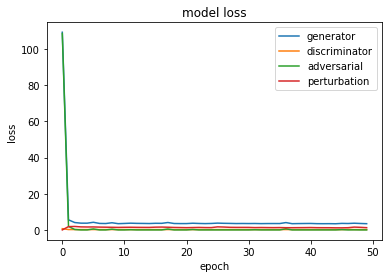

In [23]:
plt.plot(history.history['g_loss'])
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_adv_loss'])
plt.plot(history.history['g_perturb_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator', 'adversarial', 'perturbation'], loc='best')

plt.show()

Plot the generator's progress through the epochs:


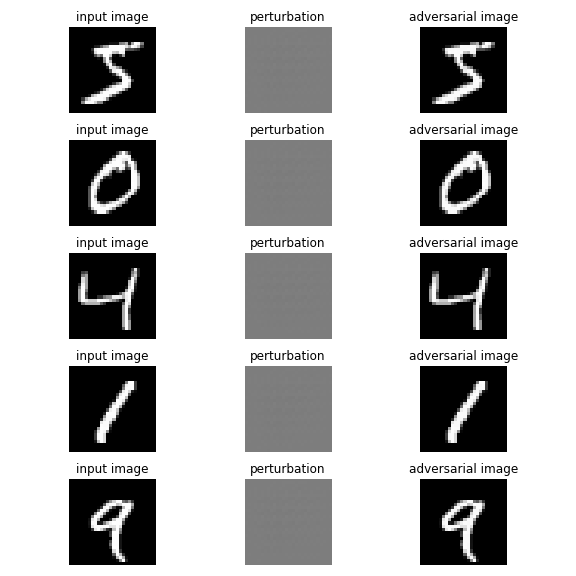

In [24]:
import tensorflow_docs.vis.embed as embed

image_pattern = f'{IMAGES_DIR}/{BASE_FILENAME}*.png'
gif_path = f'{IMAGES_DIR}/{BASE_FILENAME}.gif'

images_to_gif(image_pattern, gif_path, delete_frames=True)
embed.embed_file(gif_path)

### Classifying generated images using `MNISTConvTarget`

We'll test the generator's performance by classifying the adversarial images it creates for the test set using the `MNISTConvTarget` model.

Get a sample of test set images:

In [25]:
test_filter = (test_labels != TARGET_LABEL)

test_images, test_labels = test_images[test_filter], test_labels[test_filter]
test_images.shape

(8990, 28, 28, 1)

In [26]:
test_images_sample = tf.data.Dataset.from_tensor_slices(test_images).batch(1).take(NUM_IMAGES)

Generate and classify adversarial images obtained for the sample:

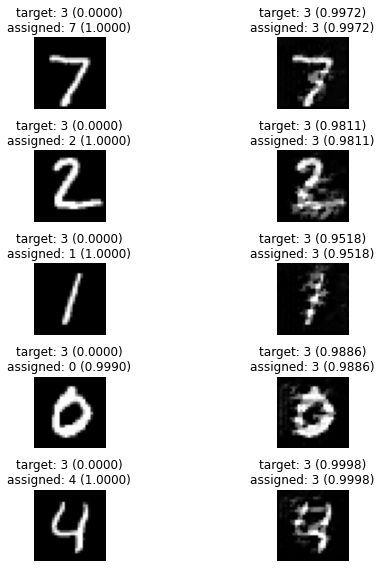

In [27]:
_, ax = plt.subplots(NUM_IMAGES, 2, figsize=(8, 8))

for i, real_image in enumerate(test_images_sample):
    perturbation = generator(real_image, training=False)

    if PERTURB_BOUND:
        perturbation = tf.clip_by_value(perturbation, -PERTURB_BOUND, PERTURB_BOUND)
        
    adv_image = tf.clip_by_value(real_image + perturbation, -1, 1)

    for j, image in enumerate([real_image, adv_image]):
        probs = target.predict(image)
        max_label = probs.argmax()
        max_prob = probs.max()
        target_prob = probs[0][TARGET_LABEL]

        ax[i, j].imshow(image[0, :, :, 0] * 127.5 + 127.5, cmap='gray', vmin=0, vmax=255)
        ax[i, j].set_title(f'target: {TARGET_LABEL} ({target_prob:.4f})'
                           f'\nassigned: {max_label} ({max_prob:.4f})')
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()
